In [82]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  7 11:24:13 2024

@author: mrsag
"""

import yt
import numpy as np
import matplotlib.pyplot as plt
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from scipy.signal import fftconvolve
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.path import Path
from skimage import io
from skimage.transform import resize
import plotly.graph_objects as go
from copy import deepcopy
from tqdm import tqdm

import matplotlib as mpl


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=100 # highres display

In [77]:
class polygon_plate:
    def __init__(self, edges, potential=0, resolution=100):
        self.edges = edges  # List of (x, y) points
        self.potential = potential
        self.resolution = resolution
        self.mask = None

    def is_inside(self, x, y):
        # Ray casting algorithm for point-in-polygon
        n = len(self.edges)
        inside = False
        px, py = x, y
        for i in range(n):
            x0, y0 = self.edges[i]
            x1, y1 = self.edges[(i + 1) % n]
            if ((y0 > py) != (y1 > py)):
                x_intersect = (x1 - x0) * (py - y0) / (y1 - y0 + 1e-10) + x0
                if px < x_intersect:
                    inside = not inside
        return inside

    def generate_mask(self, xx, yy):
        mask = np.zeros_like(xx, dtype=bool)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                if self.is_inside(xx[i, j], yy[i, j]):
                    mask[i, j] = True
        self.mask = mask
        return mask


class simulationbox2d:
    def __init__(self, resolution_x=300, resolution_y=300, box_x=1, box_y=1,
                 b_y0=0, b_x0=0, b_y1=0, b_x1=0,
                 potential_offset=0, match_boundary=True, potential_given_on_boundary=False):

        self.box_x = box_x
        self.box_y = box_y
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y

        self.yy, self.xx = np.mgrid[0:self.box_y:resolution_y*1j, 0:self.box_x:resolution_x*1j]
        self.potential = np.zeros_like(self.xx) + potential_offset

        def resample_boundary(boundary, target_length):
            if isinstance(boundary, (int, float)) and boundary == 0:
                return np.zeros(target_length)
            boundary = np.array(boundary)
            x_old = np.linspace(0, 1, len(boundary))
            x_new = np.linspace(0, 1, target_length)
            return np.interp(x_new, x_old, boundary)

        # Boundary setup
        self.b_y0 = resample_boundary(b_y0, resolution_x)  # bottom edge (y=0)
        self.b_y1 = resample_boundary(b_y1, resolution_x)  # top edge    (y=1)
        self.b_x0 = resample_boundary(b_x0, resolution_y)  # left edge   (x=0)

        delta_y0 = self.b_x0[0] - self.b_y0[0]
        delta_y1 = self.b_x0[-1] - self.b_y1[0]
        self.b_y0 += delta_y0
        self.b_y1 += delta_y1

        if match_boundary:
            self.b_x1 = np.linspace(self.b_y0[-1], self.b_y1[-1], resolution_y)
        else:
            self.b_x1 = resample_boundary(b_x1, resolution_y)

        # Apply boundary values
        self.potential[0, :] = self.b_y0         # y = 0 (bottom)
        self.potential[-1, :] = self.b_y1        # y = 1 (top)
        self.potential[:, 0] = self.b_x0         # x = 0 (left)
        self.potential[:, -1] = self.b_x1        # x = 1 (right)

        self.fixed_mask = np.zeros_like(self.potential, dtype=bool)
        if potential_given_on_boundary:
            self.fixed_mask[0, :] = True
            self.fixed_mask[-1, :] = True
            self.fixed_mask[:, 0] = True
            self.fixed_mask[:, -1] = True

    def add_polygon_plate(self, poly):
        mask = poly.generate_mask(self.xx, self.yy)
        self.potential[mask] = poly.potential
        self.fixed_mask[mask] = True


    def add_disk_plate(self, center, radius, potential=0):
        """
        Adds a circular plate (disk) to the simulation domain.

        Parameters:
        - center: (x, y) tuple for center of the disk
        - radius: radius of the disk (in simulation units)
        - potential: potential to assign to the disk
        """
        cx, cy = center
        distance = np.sqrt((self.xx - cx)**2 + (self.yy - cy)**2)
        mask = distance <= radius
        self.potential[mask] = potential
        self.fixed_mask[mask] = True


        def add_image(self, image, threshold=0.5, potential=0):
            """
            Adds a fixed potential region based on a grayscale image mask.

            Parameters:
            - image_path: path to the image file
            - threshold: normalized threshold (0–1) for deciding potential region
            - potential: potential value to assign above threshold
            """
            
            # Resize to match simulation resolution
            image=np.flip(image,axis=0)
            threshold /= np.max(image)
            resized_image = resize(image, (self.resolution_x, self.resolution_y), anti_aliasing=True)

            # Create mask where intensity > threshold
            mask = resized_image > threshold

            # Apply potential and fix those positions
            self.potential[mask] = potential
            self.fixed_mask[mask] = True

    def solve(self, max_iterations=10000, tolerance=1e-4):
        with tqdm(total=max_iterations, desc="Jacobi Iteration", colour='green', ncols=500, dynamic_ncols=True) as pbar:
            for it in range(max_iterations):
                potential_old = self.potential.copy()

                # Jacobi update
                self.potential[1:-1, 1:-1] = 0.25 * (
                    potential_old[1:-1, 2:] +
                    potential_old[1:-1, :-2] +
                    potential_old[2:, 1:-1] +
                    potential_old[:-2, 1:-1]
                )

                # Restore fixed values
                self.potential[self.fixed_mask] = potential_old[self.fixed_mask]

                # Check for convergence
                delta = np.abs(self.potential - potential_old).max()

                # Use tqdm.write to display iteration status without interrupting the bar
                # if it % 50 == 0:
                #     tqdm.write(f"Iteration {it}, max change: {delta:.2e}")

                # Update progress bar
                pbar.set_postfix_str(f"Δ={delta:.2e}")
                pbar.update(1)

                if delta < tolerance:
                    tqdm.write(f"Converged after {it} iterations")
                    break

            # Final message after the loop
            tqdm.write(f"final Max change in Itn({it+1}) - Itn({it}): {delta:.2e}")




Jacobi Iteration: 100%|██████████| 500/500 [00:04<00:00, 100.32it/s, Δ=3.02e-02]


final Max change in Itn(500) - Itn(499): 3.02e-02


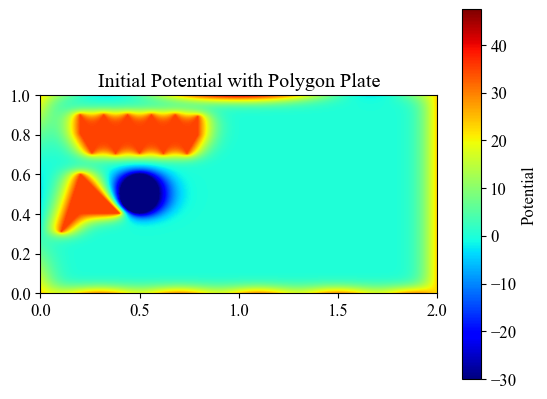

In [78]:
plate1 = polygon_plate(
    edges=[(0.1, 0.3), (0.2, 0.6), (0.4, 0.4), (0.2, 0.4)],
    potential=35
)

# Create alternating zigzag points
x_plate2 = list(np.linspace(0.2, 0.8, 11))  # Use odd number for clean pairing
y_plate2 = 0.8*np.ones(len(x_plate2))
y_plate2[::2] +=0.1
x_plate2.extend(x_plate2[::-1])
y_plate2_bottom = list(y_plate2[::-1]-0.1)
y_plate2 = list(y_plate2)
y_plate2.extend(y_plate2_bottom)

# Top zigzag path
vertices_plate2 = [(x_plate2[i], y_plate2[i]) for i in range(len(x_plate2))]

# Now you can create the polygon plate
plate2 = polygon_plate(edges=vertices_plate2, potential=35)

b_y0 = -5*np.sin(np.linspace(0,31.4159,100))
b_x0 = 1*np.linspace(-5,5,100)**2-0.1*25
b_y1 = -25*np.sin(np.linspace(0,3*3.14159,100))

sim = simulationbox2d(resolution_x=401, resolution_y=401, box_x=2, box_y=1,
                      b_y0=b_y0, b_x0 = b_x0, b_y1 = b_y1, 
                      match_boundary=True, potential_given_on_boundary=True)

sim.add_polygon_plate(plate1)
sim.add_polygon_plate(plate2)
sim.add_disk_plate(center=(0.5,0.5),radius=0.1,potential=-30)
sim.solve(max_iterations=500)

plt.imshow(sim.potential, origin='lower', cmap="jet",extent=[0,sim.box_x,0,sim.box_y])
plt.colorbar(label='Potential')
plt.title("Initial Potential with Polygon Plate")
plt.show()


In [83]:
class SimulationBox3D:
    def __init__(self, resolution_x=50, resolution_y=50, resolution_z=50,
                 box_x=1.0, box_y=1.0, box_z=1.0, potential_offset=0):
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y
        self.resolution_z = resolution_z

        self.box_x = box_x
        self.box_y = box_y
        self.box_z = box_z

        # Create a proper Cartesian grid
        self.x, self.y, self.z = np.meshgrid(
            np.linspace(0, box_x, resolution_x),
            np.linspace(0, box_y, resolution_y),
            np.linspace(0, box_z, resolution_z),
            indexing='ij'
        )

        self.potential = np.full_like(self.x, potential_offset, dtype=float)
        self.fixed_mask = np.zeros_like(self.potential, dtype=bool)

    def add_sphere(self, center, radius, potential=0):
        cx, cy, cz = center
        mask = ((self.x - cx)**2 + (self.y - cy)**2 + (self.z - cz)**2) <= radius**2
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def add_box(self, x_bounds, y_bounds, z_bounds, potential=0):
        x0, x1 = x_bounds
        y0, y1 = y_bounds
        z0, z1 = z_bounds
        mask = ((self.x >= x0) & (self.x <= x1) &
                (self.y >= y0) & (self.y <= y1) &
                (self.z >= z0) & (self.z <= z1))
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def add_cylinder(self, base_center, radius, height, axis='z', potential=0):
        cx, cy, cz = base_center
        if axis == 'z':
            mask = (((self.x - cx)**2 + (self.y - cy)**2 <= radius**2) &
                    (self.z >= cz) & (self.z <= cz + height))
        elif axis == 'x':
            mask = (((self.y - cy)**2 + (self.z - cz)**2 <= radius**2) &
                    (self.x >= cx) & (self.x <= cx + height))
        elif axis == 'y':
            mask = (((self.x - cx)**2 + (self.z - cz)**2 <= radius**2) &
                    (self.y >= cy) & (self.y <= cy + height))
        else:
            raise ValueError("axis must be 'x', 'y', or 'z'")
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def add_hollow_pipe(self, base_center, radius, thickness, height, axis='z', potential=0):
        cx, cy, cz = base_center
        if axis == 'z':
            mask = (((self.x - cx)**2 + (self.y - cy)**2 <= (radius+thickness/2)**2) &
                    ((self.x - cx)**2 + (self.y - cy)**2 >= (radius-thickness/2)**2)
                    (self.z >= cz) & (self.z <= cz + height))
        elif axis == 'x':
            mask = (((self.y - cy)**2 + (self.z - cz)**2 <= (radius+thickness/2)**2) &
                    ((self.y - cy)**2 + (self.z - cz)**2 >= (radius-thickness/2)**2) &
                    (self.x >= cx) & (self.x <= cx + height))
        elif axis == 'y':
            mask = (((self.x - cx)**2 + (self.z - cz)**2 <= (radius+thickness/2)**2) &
                    ((self.x - cx)**2 + (self.z - cz)**2 >= (radius-thickness/2)**2)
                    (self.y >= cy) & (self.y <= cy + height))
        else:
            raise ValueError("axis must be 'x', 'y', or 'z'")
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def add_ellipsoid(self, center, radii, potential=0):
        cx, cy, cz = center
        rx, ry, rz = radii
        mask = (((self.x - cx)/rx)**2 + ((self.y - cy)/ry)**2 + ((self.z - cz)/rz)**2 <= 1)
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def add_hyperboloid(self, center, coeffs, waist=1, axis="z", potential=0):
        cx, cy, cz = center
        a, b, c = coeffs
        if axis=="x":
            mask = (-((self.x - cx)/a)**2 + ((self.y - cy)/b)**2 + ((self.z - cz)/c)**2 <= waist**2)
        if axis=="y":
            mask = (((self.x - cx)/a)**2 - ((self.y - cy)/b)**2 + ((self.z - cz)/c)**2 <= waist**2)
        if axis=="z":
            mask = (((self.x - cx)/a)**2 + ((self.y - cy)/b)**2 - ((self.z - cz)/c)**2 <= waist**2)

        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def add_plane(self, coefficients, thickness=0.01, potential=0):
        A, B, C, D = coefficients
        norm = np.sqrt(A**2 + B**2 + C**2)
        distance = (A * self.x + B * self.y + C * self.z + D) / norm
        mask = np.abs(distance) <= thickness / 2
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

    def solve(self, max_iter=1000, tol=1e-4, method='jacobi', verbose=False):
        V = self.potential.copy()
        
        with tqdm(total=max_iter, desc="Solver Iteration", colour='green', ncols=100, dynamic_ncols=False) as pbar:
            for it in range(max_iter):
                V_old = V.copy()
                
                if method == 'jacobi':
                    V_new = V.copy()
                    V_new[1:-1, 1:-1, 1:-1] = 1/6 * (
                        V[2:, 1:-1, 1:-1] + V[:-2, 1:-1, 1:-1] +
                        V[1:-1, 2:, 1:-1] + V[1:-1, :-2, 1:-1] +
                        V[1:-1, 1:-1, 2:] + V[1:-1, 1:-1, :-2]
                    )
                    mask = ~self.fixed_mask[1:-1, 1:-1, 1:-1]
                    V[1:-1, 1:-1, 1:-1][mask] = V_new[1:-1, 1:-1, 1:-1][mask]
                elif method == 'gauss-seidel':
                    for i in range(1, self.resolution_x - 1):
                        for j in range(1, self.resolution_y - 1):
                            for k in range(1, self.resolution_z - 1):
                                if not self.fixed_mask[i, j, k]:
                                    V[i, j, k] = 1/6 * (V[i+1, j, k] + V[i-1, j, k] +
                                                    V[i, j+1, k] + V[i, j-1, k] +
                                                    V[i, j, k+1] + V[i, j, k-1])
                else:
                    raise ValueError("Unknown method")

                diff = np.abs(V - V_old).max()
                
                # Update progress bar
                pbar.set_postfix_str(f"Δ={diff:.2e}")
                pbar.update(1)

                if diff < tol:
                    if verbose:
                        tqdm.write(f"Converged at iteration {it}, max change: {diff:.2e}")
                    break
        
        self.potential = V
        tqdm.write(f"Final Max change in iteration {it+1}: {diff:.2e}")


In [84]:
box = SimulationBox3D(50, 50, 50, box_x=2, box_y=1, box_z=1)
# box.add_sphere(center=(1, 0.5, 0.5), radius=0.3, potential=10)
box.add_cylinder(base_center=(0,0,0),radius=0.1,axis="x",potential=-5,height=2)
box.add_cylinder(base_center=(0,1,0),radius=0.1,axis="x",potential=5,height=2)
box.add_cylinder(base_center=(0,0,1),radius=0.1,axis="x",potential=5,height=2)
box.add_cylinder(base_center=(0,1,1),radius=0.1,axis="x",potential=-5,height=2)
box.add_hollow_pipe(base_center=(0,0.5,0.5),radius=0.1,axis="x",height=2, thickness=0.05,potential=5)

box.solve(max_iter=200)

Solver Iteration: 100%|██████████████████████████████| 200/200 [00:00<00:00, 219.33it/s, Δ=4.73e-03]

Final Max change in iteration 200: 4.73e-03


In [87]:
# Normalize potential values for better visualization (optional)
potential = box.potential


# Define custom colorscale mimicking "jet" colormap
colors = [
    [0, "rgb(0,0,128)"],   # Dark blue
    [0.25, "rgb(0,0,255)"], # Blue
    [0.5, "rgb(0,255,255)"], # Cyan
    [0.75, "rgb(255,255,0)"], # Yellow
    [1, "rgb(255,0,0)"]   # Red
]

# Flattened coordinates across actual physical dimensions
x_vals = np.repeat(np.linspace(0, box.box_x, box.resolution_x), box.resolution_y * box.resolution_z)
y_vals = np.tile(np.repeat(np.linspace(0, box.box_y, box.resolution_y), box.resolution_z), box.resolution_x)
z_vals = np.tile(np.linspace(0, box.box_z, box.resolution_z), box.resolution_x * box.resolution_y)

fig = go.Figure(data=go.Volume(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    value=box.potential.flatten(),
    opacity=0.3,
    surface_count=200,
    colorscale=colors
))


fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Potential Field Density Plot',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show(renderer="browser")